# Sea breeze frontogenesis

### Description
This recipe demonstrates the identification of sea breeze objects using moisture frontogenesis from a month of hourly [BARRA-R2](https://dx.doi.org/10.25914/1x6g-2v48) data. This code as included in WxSysLib is a subset of [andrewbrown31/sea_breeze](https://github.com/andrewbrown31/sea_breeze), which is in support of Brown et al. (submitted to MWR).

The BARRA-R2 reanalysis product has 12 km grid spacing. This is fine enough to represent some sea breeze processes, but will not give a full picture. The code in this manuscript can be modified to use [BARRA-C2](https://dx.doi.org/10.25914/1x6g-2v48), which will give a better sea breeze representation (grid spacing of 4 km). The BARRA-R2 model is used here for computational efficiency.

The identification method is split into three modules:
1. **Loading model data and pre-processing**
2. **Computing sea breeze diagnostics (moisture frontogenesis)**
3. **Defining sea breeze objects**

Each of these steps will be outlined in this notebook. 

The moisture frontogenesis parameter, F, is based on the [MetPy implementation](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.frontogenesis.html) (May et al. 2019). It is defined as the rate of change in the horizontal moisture gradient, but it can be expressed in terms of flow deformation, allowing it to be calculated instantaneously (Pettersen 1956, Bluestein 1993). F is intended to identify regions of frontal growth that will include sea breeze fronts. Here, we use moisture as a quantity for defining fronts, but (equivalent) potential temperature is often used.

**F will also indicate synoptic-scale fronts** as demonstrated below. The code here could be adapted for this purpose. In the sea breeze code, synoptic-scale fronts are mostly filtered by step 3...

Step 3 uses a series of filters to try and remove non-sea-breeze fronts and circulations. Here we will only use a small set of simple filters, for simplicity. **Note** that there is no tracking of objects through time within the sea breeze code, this is not currently supported.

### Data and software environment
This notebook requires direct access to the `ob53` [NCI project](https://my.nci.org.au/mancini/project/ob53/join) for BARRA-R2 data. The sea breeze code and notebook were devloped on the `analysis3-25.06` conda environment through the `xp65` [NCI project](https://my.nci.org.au/mancini/project/xp65/join). The sea breeze code is built on the following python packages:

- metpy
- xarray
- dask
- scipy
- skimage
- pandas
- numpy

This recipe was developed on an `xlarge` ARE session (14 cpu, 63 GB), and took a few minutes to run with those resources.

### References
Bluestein, H. B., 1993: Observations and Theory of Weather Systems. Vol. 2, Synoptic-Dynamic Meteorology in Midlatitudes. Oxford University Press.

May, R. M., S. C. Arms, P. Marsh, E. Bruning, J. R. Leeman, K. Goebbert, J. E. Thielen, and Z. Bruck, 2019: MetPy: A Python Package for Meteorological Data.Unidata, Boulder, Colorado, 
https://doi.org/10.5065/D6WW7G29.

Pettersen, S., 1956: Weather Analysis and Forecasting, Vol. 1, Motion and Motion Systems. 2nd ed., McGraw-Hill.

----

First load require Python functions

In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Set and load the paths for your WxSysLib installation. Remove any existing paths that may intefere

In [2]:
os.environ['WXSYSLIBDIR']='/g/data/ng72/ab4502/WxSysLib' # ⚠️ change to where your WxSysLib is placed
sys.path.append(os.environ['WXSYSLIBDIR'])

#If you have any modules on your system path that contain a "utils" module, these need to be removed
remove_paths = ['/home/548/ab4502/working/sea_breeze'] # ⚠️ change to any sys paths to remove, or leave as an empty string
for path in remove_paths:
    sys.path = np.array(sys.path)[~(np.array(sys.path) == path)].tolist()

Set up your output path for sea breeze object statistics

In [3]:
stats_output_path = "/scratch/ng72/ab4502/tmp/"  #⚠️ change to where you want the .csv output, somewhere in your own directories

Set up a dask distributed client

In [4]:
client = Client()

Import the sea breeze functions

In [6]:
from utils.diagnostics.sea_breeze import (
sea_breeze_utils,
sea_breeze_filters,
sea_breeze_funcs
)

## 1) Load model data
The first module of the sea breeze code is to load and pre-process some model data. Here we are loading data from [BARRA-R2](https://dx.doi.org/10.25914/1x6g-2v48). Note the `load_barra_variable()` function can also load BARRA-C2 data

We first set the spatial and temporal bounds. Here we consider a month of data over Australia

In [17]:
#Time bounds for a single 6-hour case
t1 = "2016-01-01 00:00"
t2 = "2016-01-31 23:00"

#Lat lon and height bounds
lat_slice = slice(-45,-10)
lon_slice = slice(110,155)

#Load surface u and v winds, as well as surface specific humidity
uas = sea_breeze_utils.load_barra_variable(
    "uas",
    t1,
    t2,
    "AUS-11",
    "1hr",
    lat_slice,
    lon_slice,
    chunks={}
)

vas = sea_breeze_utils.load_barra_variable(
    "vas",
    t1,
    t2,
    "AUS-11",
    "1hr",
    lat_slice,
    lon_slice,
    chunks={}
)

huss = sea_breeze_utils.load_barra_variable(
    "huss",
    t1,
    t2,
    "AUS-11",
    "1hr",
    lat_slice,
    lon_slice,
    chunks={}
)

Note because we are stacking up a sequence of computations on a fairly large dataset, it might be more efficient to trigger our previous computations before proceeding with calculating F.

We can trigger these with `persist()`


In [9]:
uas = uas.persist()
vas = vas.persist()
huss = huss.persist()

## 2) Computing sea breeze diagnostics (moisture frontogenesis)

This is done lazily with dask. We will plot a single time step to check the output

In [10]:
#Moisture frontogenesis
F = sea_breeze_funcs.kinematic_frontogenesis(
        huss,
        uas,
        vas
    ) 

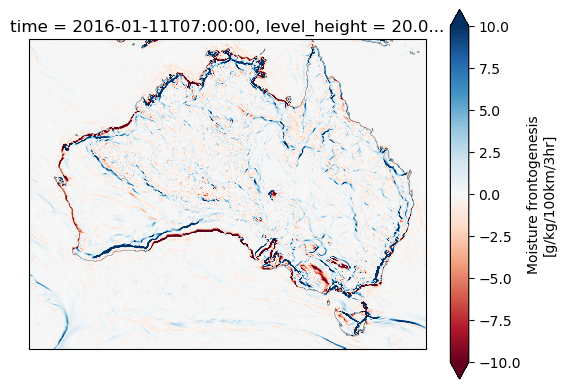

In [11]:
ax=plt.axes(projection=ccrs.PlateCarree())
F.sel(time="2016-01-11 07:00").F.plot(vmin=-10,vmax=10,cmap="RdBu")
ax.coastlines(lw=0.2)


**Note** that as well as sea breeze fronts identified along the coast by large positive values of F, there are many smaller inland fronts, as well as large fronts over the ocean south of Australia

The front to the southwest of Western Australia is a synoptic-scale cold front.

---

Again, to break up the sequence of computations, lets trigger the F computation now


In [12]:
F = F.persist()

And plot the mean of F over the month

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


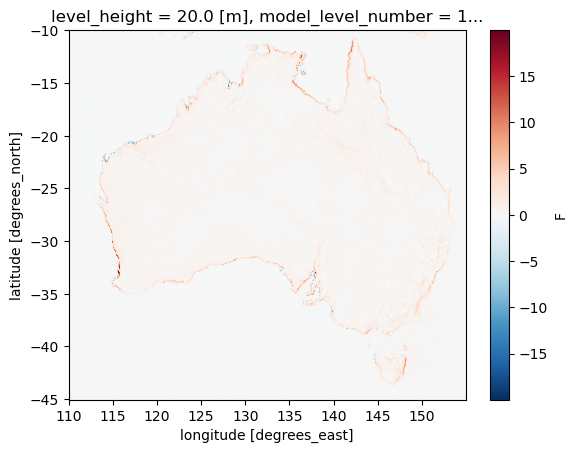

In [13]:
F.mean("time").F.plot()

We can see that on average, the F diagnostic is maximised over the coastlines, representative of sea breeze fronts

## 3) Object detection and filtering

Finally, we use a threshold on F to define candidate sea breeze objects, and then use filtering to remove objects that probably aren't sea breezes.

We hard-code a threshold of `12.68` g/kg/100km/3hr. This is equivalent to the 99.5th percentile over 6 months of Jan-Feb BARRA-R data

We only use two of the available filters here (`aspect_filter` and `area_filter`). These remove objects with an area less than 12 pixels or an aspect ratio less than 2. 

This is a very relaxed filtering approach. For examples of the use of other filters, see the [aus2200_sea_breeze_identification.ipynb](aus2200_sea_breeze_identification.ipynb) recipe.

In [15]:
#Set up filtering options. Here just use the aspect ratio and area filters
kwargs = {
    "orientation_filter":False,
    "aspect_filter":True,
    "area_filter":True,        
    "land_sea_temperature_filter":False,                    
    "temperature_change_filter":False,
    "humidity_change_filter":False,
    "wind_change_filter":False,
    "onshore_wind_filter":False,
    "dist_to_coast_filter":False,
    "output_land_sea_temperature_diff":False,        
    "time_filter":False,
    "area_thresh_pixels":12,
    "aspect_thresh":2,
    }

#Set the fixed F thresholds. This represents the 99.5th percentile 
# from BARRA-R data over a 6-month period 
thresh_F = 12.68

#Do the filtering using filter_3d
#Trigger the computation so that all the statistics are saved as a .csv file
F_objects = sea_breeze_filters.filter_3d(
    F.F,
    threshold="fixed",
    threshold_value=thresh_F,
    save_mask=False,
    filter_out_path=None,
    skipna=False,
    props_df_out_path=stats_output_path + "sb_stats_barra_r_F.csv",
    **kwargs).compute()

/g/data/ng72/ab4502/WxSysLib/utils/diagnostics/sea_breeze/sea_breeze_filters.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props_df["time_utc"] = time
/g/data/ng72/ab4502/WxSysLib/utils/diagnostics/sea_breeze/sea_breeze_filters.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props_df["time_utc"] = time
/g/data/ng72/ab4502/WxSysLib/utils/diagnostics/sea_breeze/sea_breeze_filters.py:442: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

Now we can plot the total number of sea breeze objects over the month (in UTC)

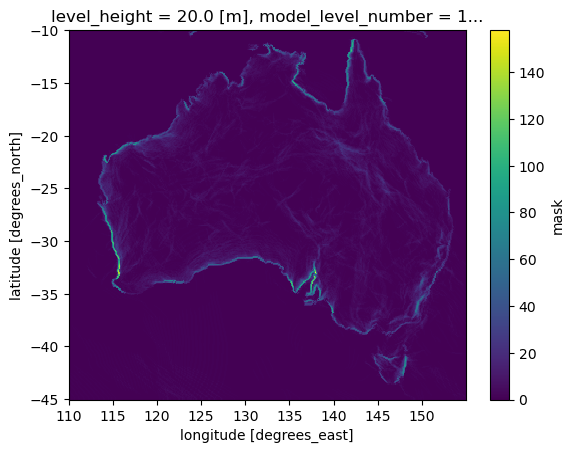

In [16]:
F_objects.mask.sum("time").plot()

And the total number of grid poins with a sea breeze objects for each hour of the day, over the month (in UTC)

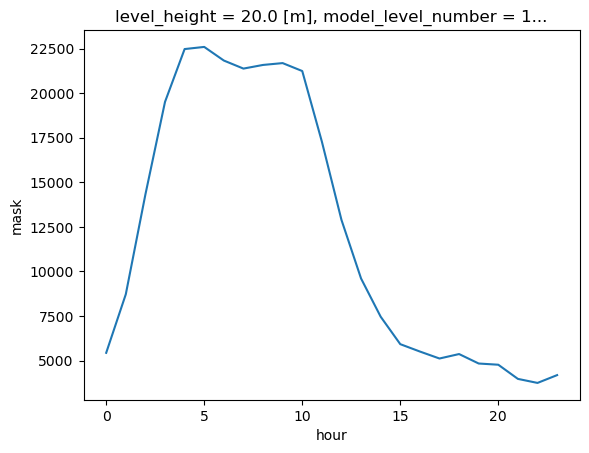

In [24]:
F_objects.mask.sum(("lat","lon")).groupby("time.hour").sum().plot()

**Note** that a large number of mis-classifications are present (e.g. overnight objects or objects very far inland). These are due to other non-sea-breeze fronts, and could potentially be removed by applying more filters (see the [aus2200_sea_breeze_identification.ipynb](aus2200_sea_breeze_identification.ipynb) recipe)